#Cross-pol investigations

In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
from astropy.modeling.models import AiryDisk2D

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')


freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

In [2]:
def get_flightinfo(fly):
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

def get_slice_xy(xes,yes,val,ax='x'):
    tol = 2
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col


def Gauss_2D_fromgrid(beam,concat,find,chind):
    xes = np.ndarray.flatten(beam.x_centers_grid[:,:,0])
    yes = np.ndarray.flatten(beam.y_centers_grid[:,:,0])
    Gfit = np.zeros(beam.V_LC_operation[:,:,0,0].shape)
    P = [1.0,0.0,concat.G_popt[chind,find,2],0.0,
        concat.G_popt[chind,find,4],concat.G_popt[chind,find,5]]
    #fits = fu.Gauss_2d_LC_func(concat.G_popt[chind,find,:-1],xes,yes)
    fits = fu.Gauss_2d_LC_func(P,xes,yes)
    reshapefits = fits.reshape((beam.x_centers_grid[:,:,0].shape))
    return reshapefits

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    return stat

In [3]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY619_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625_Corrected_amplitudes.pkl' 'FLY646_Corrected_amplitudes.pkl'
 'FLY647

In [4]:
## Look at amplitudes from flight 618, 619 620, 623, 625:

pflights = ['618','619','623','625']
normarr = np.zeros([1024,16,len(pflights)])

for i, fly in enumerate(pflights):
    if fly == '618':
        normarr[:,i] = 1.0
    elif fly == '620':
        normarr[:,i] = 1.0
    elif fly in Npolflights[1::]:
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        Gamp = np.swapaxes(fits['G_popt'][:,:,0],0,1)
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,i] = Gamp*amps[0,:,:]
    elif fly in Epolflights[1::]:
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        Gamp = np.swapaxes(fits['G_popt'][:,:,0],0,1)
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,i] = Gamp*amps[0,:,:]
    

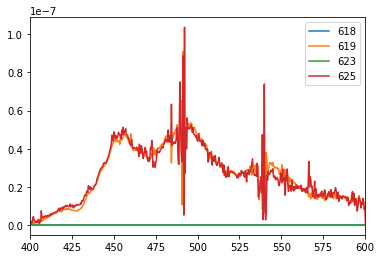

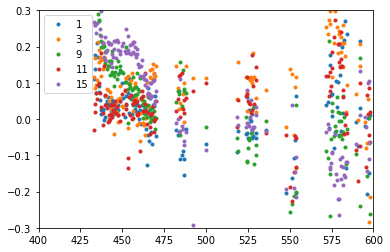

1 0.026960329988848404
3 0.08914922988074456
9 0.04438321001811236
11 0.040379595306117164
15 0.058069102187080855


In [5]:
for i, fly in enumerate(pflights):
    plt.plot(freqs,normarr[:,1,i],label=fly)
plt.xlim(400,600)
plt.legend()
plt.show()

for p in N_pols:
    plt.plot(freqs[good_freqs],
             2*(normarr[good_freqs,p,3]-normarr[good_freqs,p,1])/(normarr[good_freqs,p,3]+normarr[good_freqs,p,1]),
             label=str(p),marker='.',linestyle='None')
plt.xlim(400,600)
plt.ylim(-0.3,0.3)
plt.legend()
plt.show()

for p in N_pols:
    tt = np.mean(2*(normarr[good_freqs,p,3]-normarr[good_freqs,p,1])/(normarr[good_freqs,p,3]+normarr[good_freqs,p,1]),axis=0)
    print(p, tt)

In [6]:
## Plan: ##
# 1. Read in flight 618 (N pol flight)
# 2. divide N pols by corresponding Gaussian fits
# 3. read in Gauss fits for flight 620 (Epol flight)
# 4. divide E pols by flight 620 Gauss fits
# 5. Read in 620 flight
# 6. divide E pols by 620 fits
# 7. overplot E-pol copol (flight 620) and Epol cross pol (flight 618)
# 8. divide N pols in 620 with Gaussian fits for 618
# 9. overplot N pol copol (flight 618) and Npol cross pol (flight 620)

In [7]:
find = 900

In [8]:
# Read in Flight 618
fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest)

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest618=pickle.load(pfile)
t_cut_618=concattest618.inds_on    

fly = '620'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest)

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest620=pickle.load(pfile)
t_cut_620=concattest620.inds_on    

618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
['/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/F

In [9]:
## Read in Gaussian fit params:

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits618 = np.load(ffile)
gp_618 = fits618['G_popt'][:,:,0] # amplitude

print(gp_618)

fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
fits620 = np.load(ffile)
gp_620 = fits620['G_popt'][:,:,0] # amplitude

print(gp_620)

[[           nan 1.12507297e-11 1.03401364e-11 ... 2.21110678e-10
  1.73971254e-10 1.33771029e-10]
 [8.28151530e-09 2.88838860e-10 5.79262356e-10 ... 1.27754305e-09
  1.22742222e-09 1.15288538e-09]
 [2.28087767e-09 1.13378084e-10 1.15745340e-10 ... 1.43966192e-10
  1.45536032e-10 1.37248491e-10]
 ...
 [           nan            nan            nan ...            nan
             nan            nan]
 [1.71361994e-10 1.47711512e-11 1.56880649e-11 ... 5.77082524e-11
  3.79459388e-11 5.08132761e-11]
 [7.45100472e-09 1.07213692e-08 1.07832867e-08 ... 3.15769594e-09
  3.14032216e-09 3.11583239e-09]]
[[ 0.00000000e+00  1.74487994e-09  1.74311253e-09 ...  9.55955692e-10
   9.12808615e-10  8.67029837e-10]
 [ 3.63651681e-09 -2.01270590e-11  7.35797924e-09 ...  1.65152129e-10
   1.13489178e-10  2.37949020e-10]
 [ 7.87048609e-09  5.11090450e-09  5.17700944e-09 ...  2.36430851e-09
   2.34750625e-09  2.30763595e-09]
 ...
 [ 0.00000000e+00             nan             nan ...             nan
          

[ 4.28831085e-08 -2.85748077e+00  9.75495920e+00  1.34109007e+00
  9.17015906e+00  4.52712120e-10  0.00000000e+00]


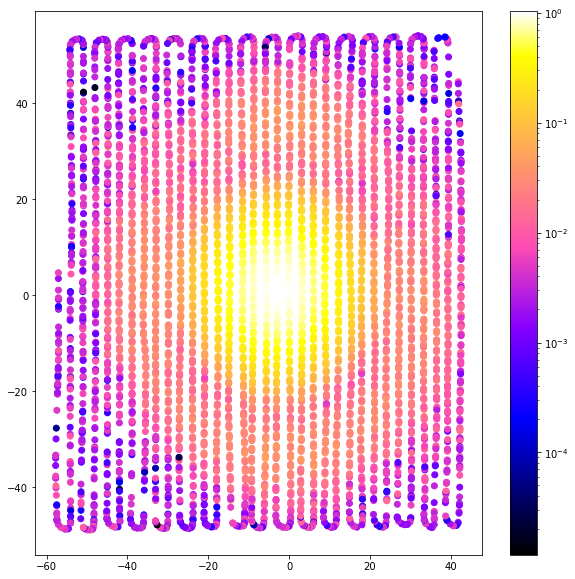

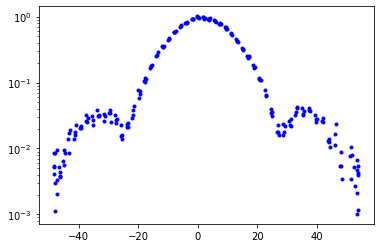

In [10]:
## Let's start by checking regular co-pol normalization - N pol: 

chind=1
print(concattest618.G_popt[chind,find,:])

x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]


# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm())
plt.colorbar()
plt.show()

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'b.',label='copol')
plt.show()


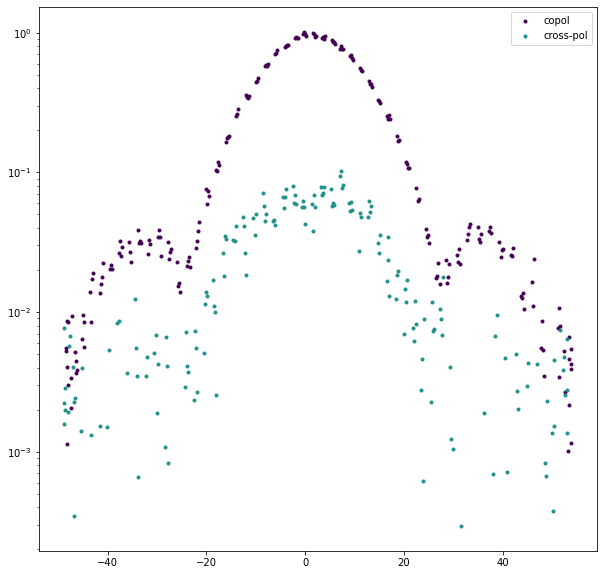

In [11]:
## Now let's plot slices together - N pol
colors=pu.cm_to_discrete('viridis', 3)

# Flight 618, N pol (1 is a good input)
chind=1

x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice

plt.figure(1,figsize=(10,10))
plt.semilogy(y[ixd],z[ixd],color=colors[0],marker='.',linestyle='None',label='copol')

## Let's look at that same channel, in cross-pol flight, divide by same value:

x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
z = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]


# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],color=colors[1],marker='.',linestyle='None',label='cross-pol')
plt.legend()
plt.show()

3.5223832952415695e-08


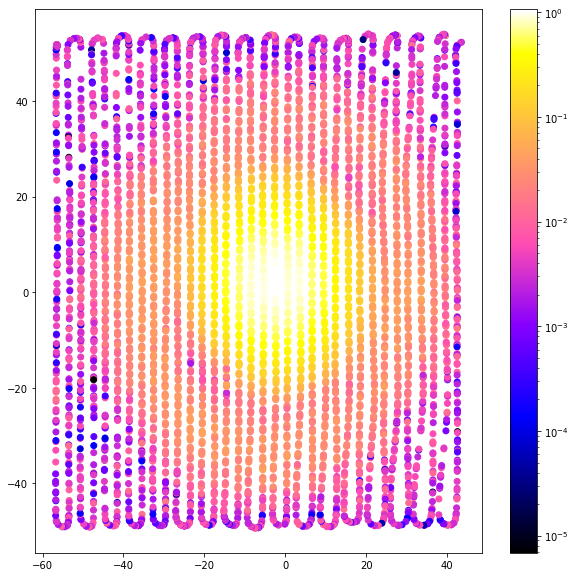

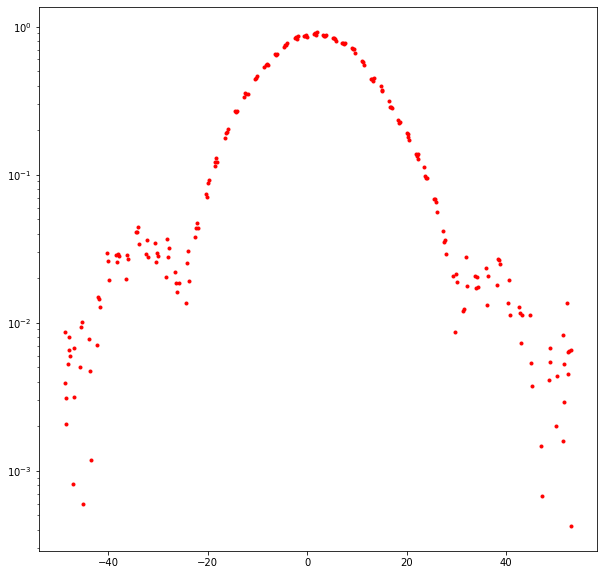

In [12]:
# Repeat for E pol

chind=0
x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
z = concattest620.V_bgsub[t_cut_620,find,chind] / np.abs(gp_620[chind,find])
print(gp_620[chind,find])

# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm())
plt.colorbar()
plt.show()

# grab a slice and plot it
plt.figure(1,figsize=(10,10))
ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')



3.5223832952415695e-08


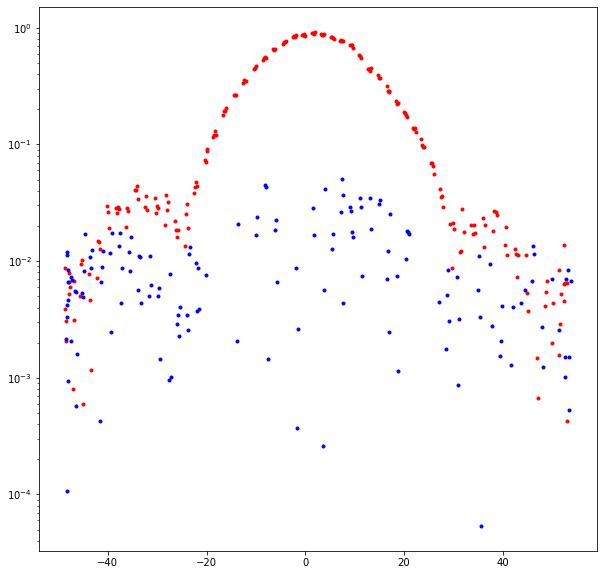

In [13]:
# Now reverse - plot slices together, E pol

# Flight 620, E pol (0 is a good input)
chind=0
x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
z = concattest620.V_bgsub[t_cut_620,find,chind] / np.abs(gp_620[chind,find])
print(gp_620[chind,find])


# grab a slice and plot it
plt.figure(1,figsize=(10,10))
ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')

# Flight 618, N pol (1 is a good input)
x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_620[chind,find]

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'b.',label='copol')
plt.show()



In [14]:
len(N_pols)

5

[ 4.28831085e-08 -2.85748077e+00  9.75495920e+00  1.34109007e+00
  9.17015906e+00  4.52712120e-10  0.00000000e+00]


<ipython-input-15-636a3d4798a4>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,5,i+1)
<ipython-input-15-636a3d4798a4>:24: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
<ipython-input-15-636a3d4798a4>:34: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.scatter(xcrs,ycrs,c=

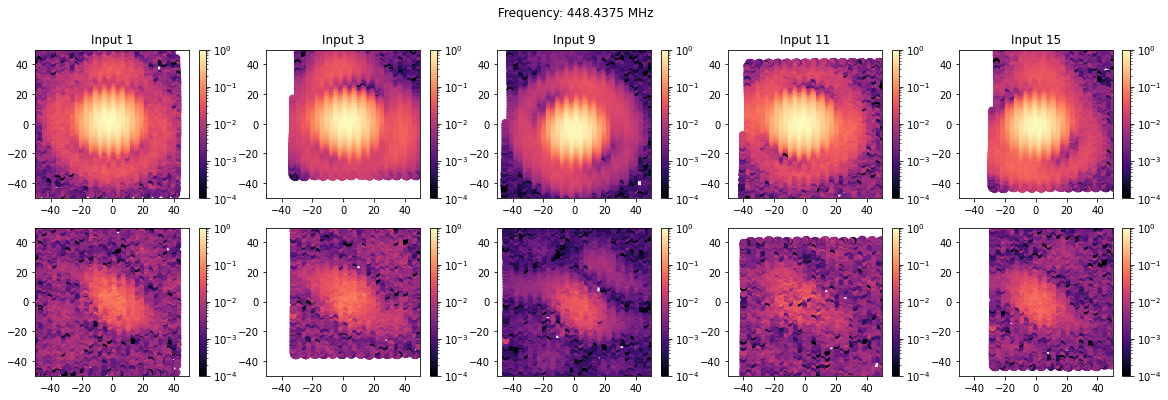

In [15]:
## Now let's plot slices together - N pol
colors=pu.cm_to_discrete('viridis', 3)
find = 900

chind=1
print(concattest618.G_popt[chind,find,:])

fig = plt.figure(figsize=(20,6))
plt.subplot(2,5,1)

for i,chind in enumerate(N_pols):
    # Flight 618, N pol (1 is a good input)
    xco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    yco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    zco = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    ycrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    zcrs = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]

    # plot scatter plot and beam map
    plt.subplot(2,5,i+1)
    plt.scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
    plt.title('Input '+str(chind))
    plt.ylim(-50,50)
    plt.xlim(-50,50)
    plt.colorbar()
    #plt.show()
    
    # plot scatter plot and beam map
    
    plt.subplot(2,5,6+i)
    plt.scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
    plt.colorbar()
    plt.ylim(-50,50)
    plt.xlim(-50,50)
plt.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()






<ipython-input-16-8f0b682fe78b>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,5,i+1)


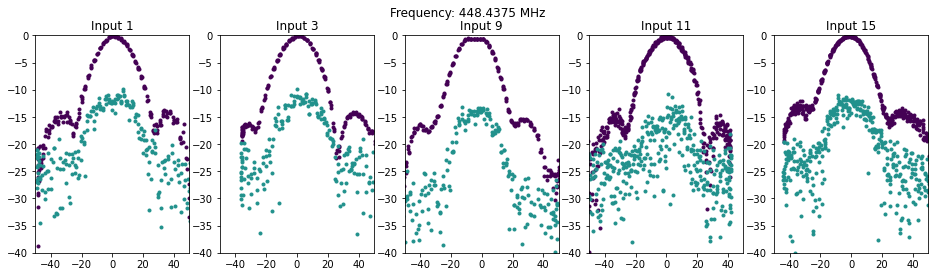

In [16]:
fig = plt.figure(figsize=(16,4))
plt.subplot(1,5,1)

for i,chind in enumerate(N_pols):
    # Flight 618, N pol (1 is a good input)
    xco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    yco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    zco = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    ycrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    zcrs = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]
    
    ixd = get_slice_xy(xco,yco,0.0,ax='x') # grabbed x slice
    plt.subplot(1,5,i+1)
    plt.title('Input '+str(chind))
    plt.plot(yco[ixd],10*np.log10(abs(zco[ixd])),color=colors[0],marker='.',linestyle='None',label='copol')
    plt.ylim(-40,0)
    plt.xlim(-50,50)
    
    ixd = get_slice_xy(xcrs,ycrs,0.0,ax='x') # grabbed x slice
    plt.plot(ycrs[ixd],10*np.log10(abs(zcrs[ixd])),color=colors[1],marker='.',linestyle='None',label='cross-pol')
    plt.ylim(-40,0)
    plt.xlim(-50,50)

plt.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()


[ 4.28831085e-08 -2.85748077e+00  9.75495920e+00  1.34109007e+00
  9.17015906e+00  4.52712120e-10  0.00000000e+00]


<ipython-input-23-53252712ad50>:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
<ipython-input-23-53252712ad50>:33: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axs[1,i].scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
<ipython-input-23-53252712ad50>:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0

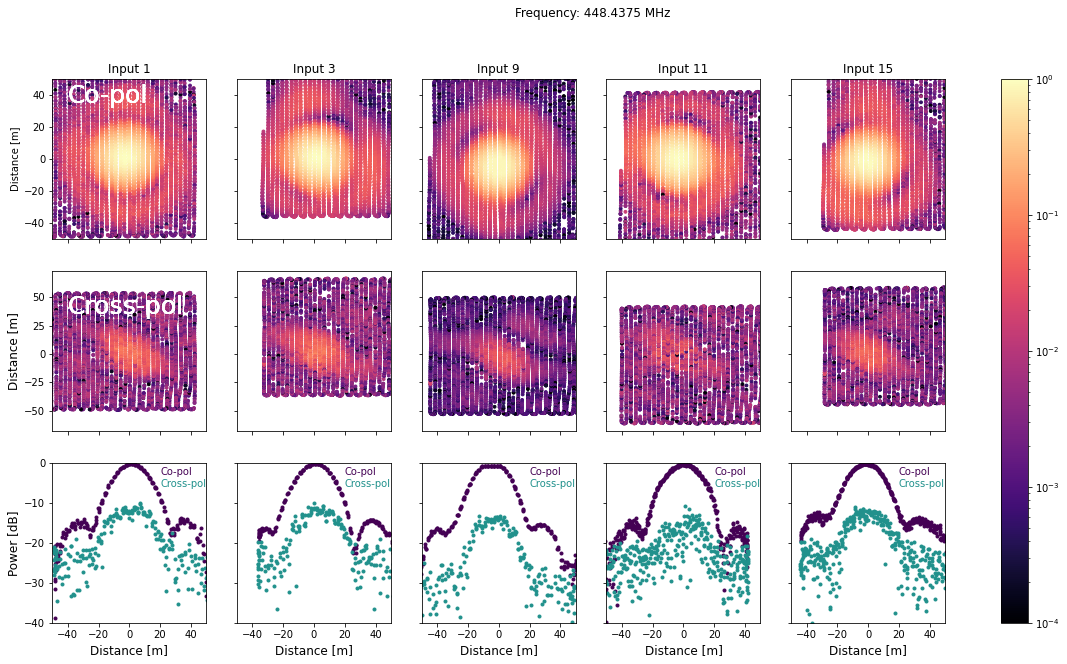

In [23]:
## Now let's plot slices together - N pol
colors=pu.cm_to_discrete('viridis', 3)
find = 900

chind=1
print(concattest618.G_popt[chind,find,:])

fig, axs = plt.subplots(3,5, sharex=True,sharey='row',figsize=(20,10))

for i,chind in enumerate(N_pols):
    # Flight 618, N pol (1 is a good input)
    xco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    yco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    zco = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    ycrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    zcrs = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]

    # plot scatter plot and beam map
    axs[0,i].scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
    axs[0,0].text(-40,35,'Co-pol',color='white',fontsize=25)
    axs[0,0].set_ylabel('Distance [m]',fontsize=10)
    axs[0,i].set_title('Input '+str(chind))
    
    axs[0,i].set_ylim(-50,50)
    axs[0,i].set_xlim(-50,50)
    #axs[0,i].colorbar()
    
    # plot scatter plot and beam map
    
    im = axs[1,i].scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,s=8,norm=LogNorm())
    axs[1,0].text(-40,35,'Cross-pol',color='white',fontsize=25)
    axs[1,0].set_ylabel('Distance [m]',fontsize=12)
    #axs[1,i].colorbar()
    #axs[1,i].ylim(-50,50)
    #axs[1,i].xlim(-50,50)
    
    
    # plot a cross-section
    ixd = get_slice_xy(xco,yco,0.0,ax='x') # grabbed x slice
    axs[2,i].plot(yco[ixd],10*np.log10(abs(zco[ixd])),color=colors[0],marker='.',linestyle='None',label='copol')
    
    ixd = get_slice_xy(xcrs,ycrs,0.0,ax='x') # grabbed x slice
    axs[2,i].plot(ycrs[ixd],10*np.log10(abs(zcrs[ixd])),color=colors[1],marker='.',linestyle='None',label='cross-pol')
    axs[2,i].text(20,-3,'Co-pol',color=colors[0])
    axs[2,i].text(20,-6,'Cross-pol',color=colors[1])
    axs[2,0].set_ylabel('Power [dB]',fontsize=12)
    axs[2,i].set_ylim(-40,0.1)
    axs[2,i].set_xlim(-50,50)
    axs[2,i].set_xlabel('Distance [m]',fontsize=12)
fig.colorbar(im, ax=axs.ravel().tolist())   
fig.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()

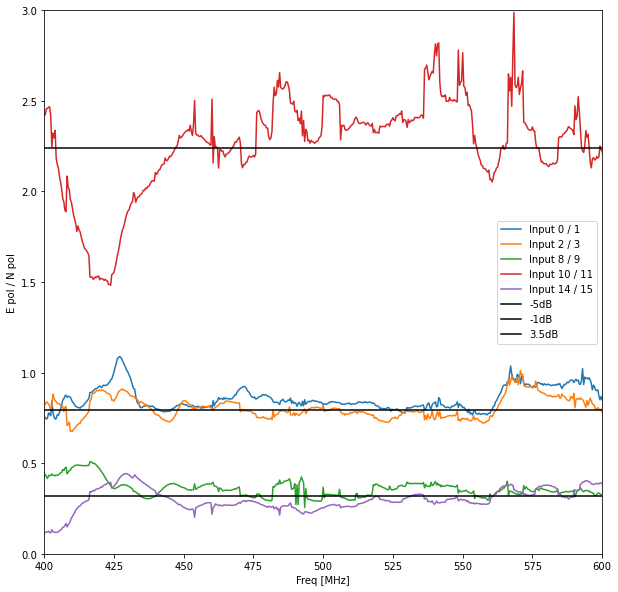

In [13]:
# check the ratio of gains between X and Y pols, to compare to 360 rotations
plt.figure(1,figsize=(10,10))
for chind in pols:
    plt.plot(freqs,gp_620[chind,:]/gp_618[chind+1,:],label='Input '+str(chind)+' / '+str(chind+1))
plt.xlim(400,600)
plt.ylim(0,3)
plt.axhline(10**(-5.0/10.),label='-5dB',color='black')
plt.axhline(10**(-1/10.),label='-1dB',color='black')
plt.axhline(10**(3.5/10.),label='3.5dB',color='black')
plt.ylabel('E pol / N pol')
plt.xlabel('Freq [MHz]')
plt.legend()
plt.show()

In [ ]:
## Now let's plot slices together - N pol
colors=pu.cm_to_discrete('viridis', 3)
find = 900

chind=1
print(concattest618.G_popt[chind,find,:])

fig = plt.figure(figsize=(20,10))
plt.subplot(2,5,1)

for i,chind in enumerate(N_pols):
    # Flight 618, N pol (1 is a good input)
    xco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    yco = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    zco = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

    ## Let's look at that same channel, in cross-pol flight, divide by same value:
    xcrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    ycrs = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    zcrs = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]

    # plot scatter plot and beam map
    plt.subplot(2,5,i+1)
    plt.scatter(xco,yco,c=zco,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
    plt.ylim(-50,50)
    plt.xlim(-50,50)
    plt.colorbar()
    #plt.show()
    
    # plot scatter plot and beam map
    
    plt.subplot(2,5,6+i)
    plt.scatter(xcrs,ycrs,c=zcrs,cmap=cm.magma,vmax=1.0,vmin=1E-4,norm=LogNorm())
    plt.colorbar()
    plt.ylim(-50,50)
    plt.xlim(-50,50)
plt.suptitle('Frequency: '+str(freqs[find])+' MHz')
plt.show()






[0, 2, 8, 10, 14]


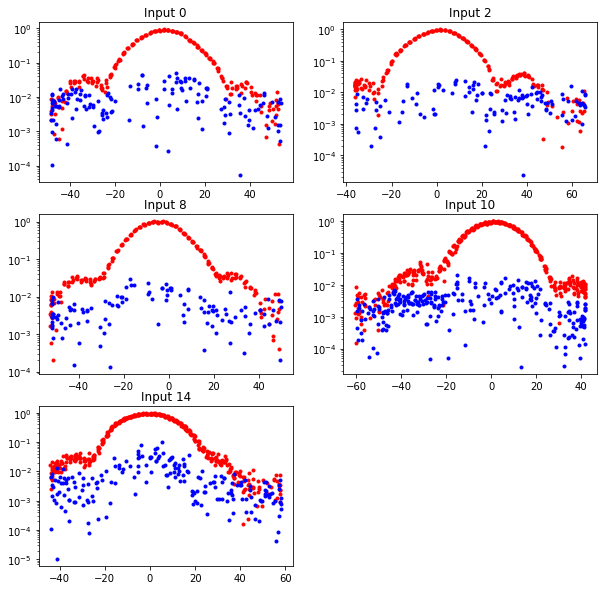

In [14]:
# Now let's try to do this for all pols

print(pols)

# E pols 

# Flight 620, E pol (0 is a good input)
plt.figure(1,figsize=(10,10))
for cc, chind in enumerate(E_pols):
    plt.subplot(3,2,cc+1)
    x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    z = concattest620.V_bgsub[t_cut_620,find,chind] / np.abs(gp_620[chind,find])


    # grab a slice and plot it
    plt.figure(1,figsize=(10,10))
    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
    plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')

    # Flight 618, N pol (1 is a good input)
    x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_620[chind,find]

    # grab a slice and plot it

    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
    plt.semilogy(y[ixd],z[ixd],'b.',label='copol')
    plt.title('Input '+str(chind))
plt.show()



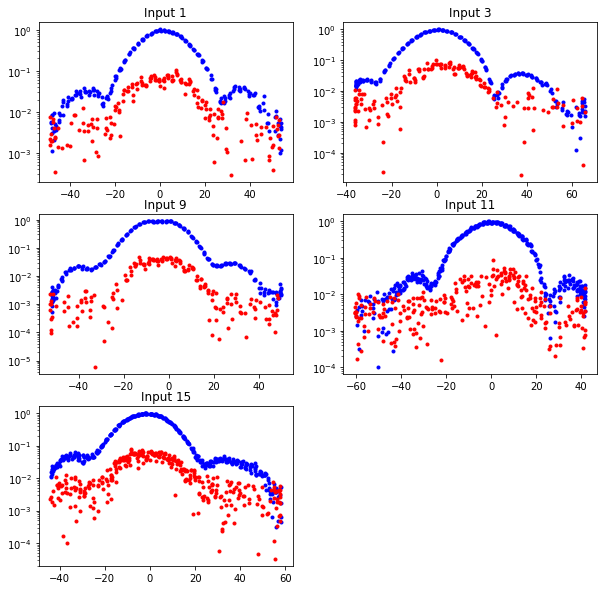

In [15]:
# Flight 618, N pol (1 is a good input)

plt.figure(1,figsize=(10,10))
for cc, chind in enumerate(N_pols):
    plt.subplot(3,2,cc+1)
    x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    z = concattest618.V_bgsub[t_cut_618,find,chind] / gp_618[chind,find]

    # grab a slice and plot it

    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice

    plt.figure(1,figsize=(10,10))
    plt.semilogy(y[ixd],z[ixd],'b.',label='copol')

    ## Let's look at that same channel, in cross-pol flight, divide by same value:

    x = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,0]
    y = concattest620.drone_xyz_per_dish_interp[chind,t_cut_620,1]
    z = concattest620.V_bgsub[t_cut_620,find,chind] / gp_618[chind,find]

    # grab a slice and plot it

    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
    plt.semilogy(y[ixd],z[ixd],'r.',label='cross-pol')
    plt.title('Input '+str(chind))
plt.show()

In [47]:
# That's all great, let's actually make a beam and stuff though for the slicing

# This doesn't work, it seems like the code is actually using the gaussian fits for the cross pol and applyng
# them, not worth futzing with right now

pflights = ['618','620']

find=900

flightarr = np.zeros([64,64,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.ones([64,64,16,len(pflights)])

fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest[fi])

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest1=pickle.load(pfile)
t_cut=concattest1.inds_on

beam618=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)


fly = '620'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest[fi])

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest1=pickle.load(pfile)
t_cut=concattest1.inds_on

beam620=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)

618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'>
start of big ass loop is: 2023-10-17 12:19:26.720740
end of chan/freq loop is: 2023-10-17 12:19:29.501275       


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:329: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)


620 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl'>
start of big ass loop is: 2023-10-17 12:19:34.298768
end of chan/freq loop is: 2023-10-17 12:19:37.534710       


In [48]:
beam620.V_LC_mean.shape 

(64, 64, 1, 16, 1)

Text(0.5, 0.98, 'Frequency 448.4375 MHz')

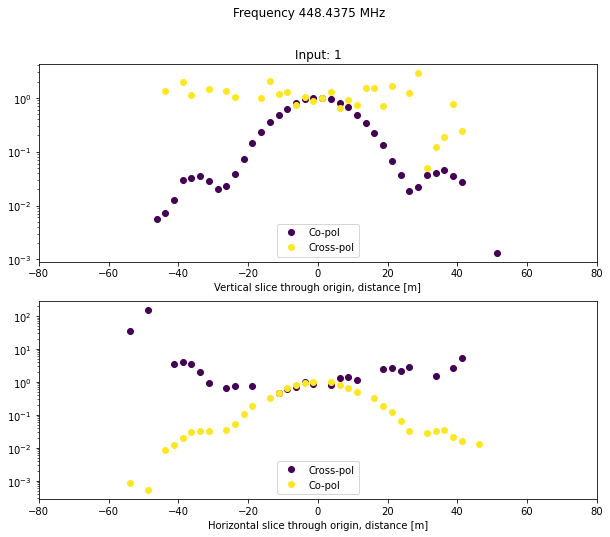

In [56]:
colors=pu.cm_to_discrete('viridis', len(pflights))
i=0
xx = 0
chind = pols[0]
colx = get_slice(beam618,beam618.V_LC_mean[:,:,0,chind,0],xx,'v')
coly = get_slice(beam618,beam618.V_LC_mean[:,:,0,chind,0],xx,'h')

fig = plt.figure(figsize=(10,8))

chind = 1 # N pol
cox = beam618.V_LC_mean[:,:,0,chind,0]
cyx = beam620.V_LC_mean[:,:,0,chind,0] / beam618.V_LC_mean[:,:,0,chind,0]

plt.subplot(2,1,1)
plt.semilogy(beam618.y_centers_grid[colx,:,0],cox[colx,:],'o',
             color=colors[0],label='Co-pol')
plt.semilogy(beam618.y_centers_grid[colx,:,0],cyx[colx,:],'o',
             color=colors[1],label='Cross-pol')
plt.title('Input: '+str(chind))
#plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.xlabel('Vertical slice through origin, distance [m]')
plt.legend(loc='lower center')

plt.subplot(2,1,2)

plt.semilogy(beam618.x_centers_grid[:,coly,0],cyx[:,coly],'o',
             color=colors[0],label='Cross-pol')
plt.semilogy(beam618.x_centers_grid[:,coly,0],cox[:,coly],'o',
             color=colors[1],label='Co-pol')
#plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.xlabel('Horizontal slice through origin, distance [m]')
plt.legend(loc='lower center')
plt.suptitle('Frequency '+str(freqs[find])+' MHz')

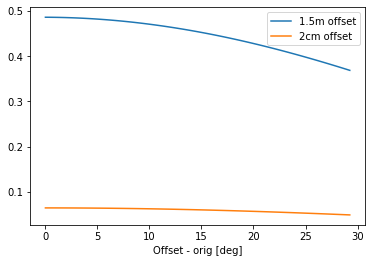

In [90]:
xes = np.arange(0.1,100)
z = 177

angl = np.degrees(np.arctan2(xes,z))
angl2 = np.degrees(np.arctan2(xes+1.5,z))
angl3 = np.degrees(np.arctan2(xes+0.2,z))

plt.plot(angl,angl2-angl,label='1.5m offset')
plt.plot(angl,angl3-angl,label='2cm offset')
plt.xlabel('Offset - orig [deg]')
plt.legend()
plt.show()